In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score

from sklearn.metrics import mean_squared_error

## Задание

Обозначения:

p - глубина истории, сколько измерений назад учитываем в моделях

h - горизонт прогноза , на сколько измерений вперед смотрим при моделировании (как далеко предсказываем)

1. Прочитайте базу "Потребление Энергии" и сделайте модель для сезонных изменений по data_exp_1 с глубиной прогноза h=1 и h=10 по образцу из примера для обработки ряда "цена Нефти" .

2. Оцените ошибку модели из п.2 .

3. Сделайте вывод о том, как изменилась ошибка модели по значениям h.

In [2]:
df = pd.read_csv('my_PJME_MW.csv', index_col=[0], parse_dates=[0])
df.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


In [3]:
PJME_MW = 'PJME_MW'

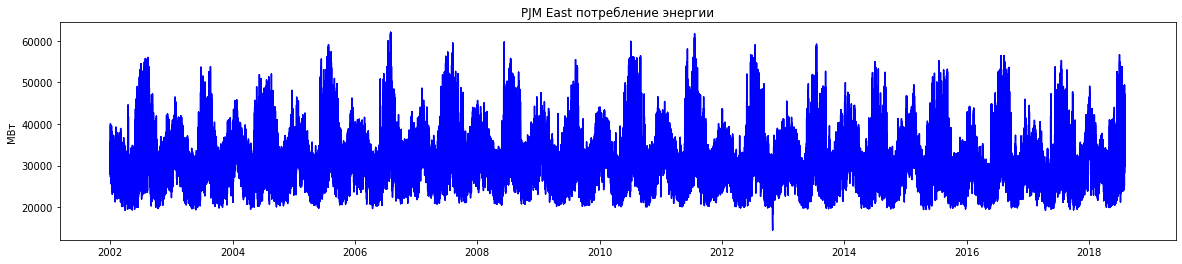

In [4]:
plt.figure(figsize =(20,4))
plt.plot(df.index, df[PJME_MW], 'b' )
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.show()

Посмотрим на данные на ресемплинге в месяц и год

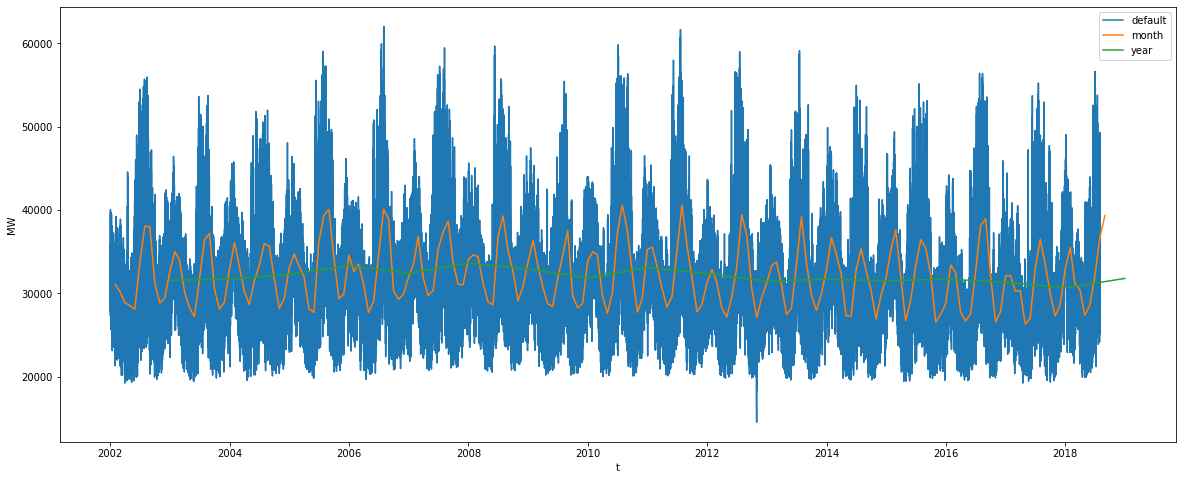

In [5]:
df_m = df.resample('M').mean()
df_y = df.resample('Y').mean()
plt.figure(figsize=(20, 8))
plt.plot(df[PJME_MW], label='default')
plt.plot(df_m[PJME_MW], label='month')
plt.plot(df_y[PJME_MW], label='year')
plt.ylabel('MW')
plt.xlabel('t')
plt.legend()
plt.show()

Посмотрим на график первой разницы

In [6]:
df['dif_1'] = df[PJME_MW].diff(1)

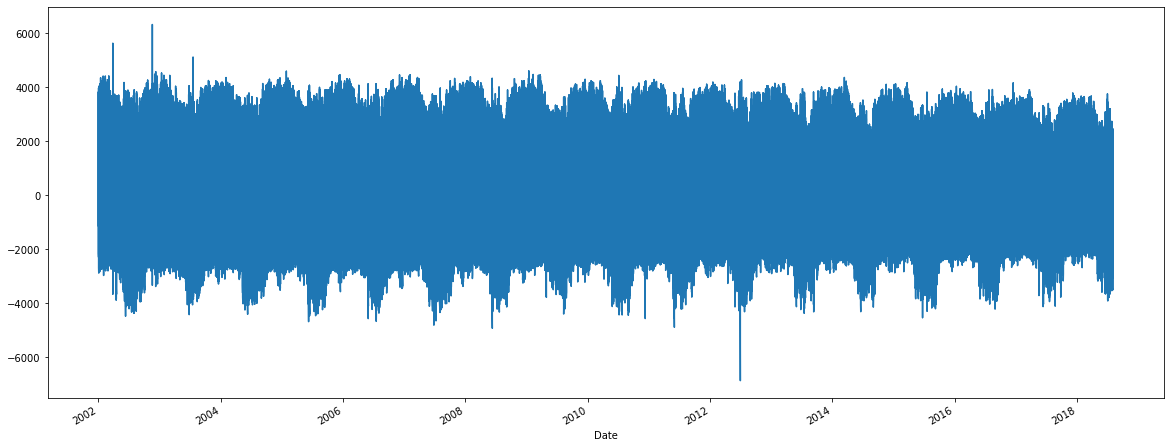

In [7]:
plt.figure(figsize=(20, 8))
df['dif_1'].plot()

Теперь проверим первые разности на стационарность

Text(0.5, 1.0, 'Brent 2010-2019')

C:\Users\alex0\Anaconda\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


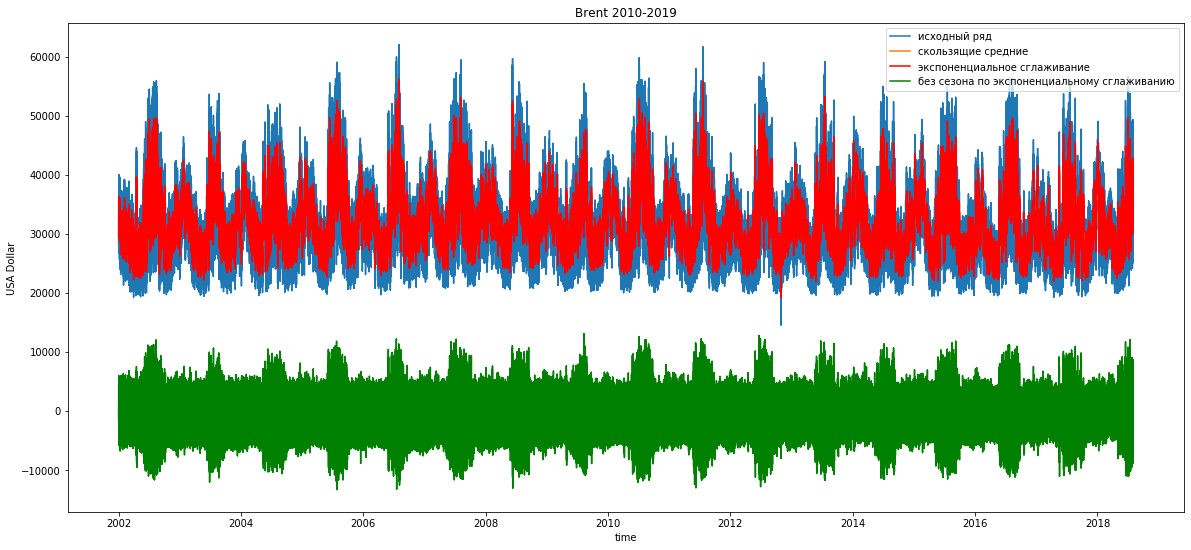

In [8]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

N2 = 24*7

exp_1 = exponential_smoothing(df[PJME_MW], 0.1)

plt.figure(figsize=(20, 9))
plt.plot(df.index, df[PJME_MW], label='исходный ряд')
plt.plot(df[PJME_MW].rolling(window=N2).mean(), label="скользящие средние");

plt.plot(df.index, exp_1, color = 'red', label="экспоненциальное сглаживание");
plt.plot(df.index, df[PJME_MW] - exp_1, color = 'green', label="без сезона по экспоненциальному сглаживанию");
plt.xlabel('time')
plt.ylabel('USA Dollar')
plt.legend()
plt.title('Brent 2010-2019')

Теперь проверим на стационарность ряд без сезона.

In [9]:
df_d = df.resample('D').mean()

In [10]:
df_seson_free = pd.DataFrame(data = (np.array(df_d[PJME_MW]).reshape((df_d[PJME_MW].shape[0],1)) - exp_1))

sm.tsa.stattools.adfuller( df_seson_free.iloc[:,0] , regression = 'ctt')

(-8.36536213858243,
 4.282974614900666e-11,
 34,
 6024,
 {'1%': -4.373054660566805,
  '5%': -3.833370706612336,
  '10%': -3.55386764946938},
 107622.59914749119)

Тест ADF показал, что это стационарный ряд.

__Теперь построим признаки для нашей будущем модели__

In [11]:
df_ = pd.DataFrame(exp_1, index=df.index)

In [12]:
 # добавим историю на глубину 5 измерения от текущего (р=5)
df_['t'] = 0
df_.iloc[1:,1]=df_.iloc[:-1,0].values
df_['t1']=0
df_.iloc[2:,2]=df_.iloc[:-2,0].values
df_['t2']=0
df_.iloc[3:,3]=df_.iloc[:-3,0].values
df_['t3']=0
df_.iloc[4:,4]=df_.iloc[:-4,0].values
df_['t4']=0
df_.iloc[5:,5]=df_.iloc[:-5,0].values
df_.fillna(0)

# добавим сглаживание (3 вида - просто для коллекции)
df_['exp_0_01'] = exponential_smoothing(df_[0], 0.01)

# добавим разности - 1-й порядок
# df_['diff1'] = 0
# df_['diff1'].iloc[1:] = df_.iloc[:-1,0] - df_.iloc[1:,0]

# добавим также исходные данные с вычетом сезона
df_['no_season'] = df[PJME_MW] - exp_1

In [13]:
df_

,0,t,t1,t2,t3,t4,exp_0_01,no_season
Date,,,,,,,,
2002-01-01,30393.000000,0.000000,0.000000,0.000000,0.000000,0.000000,30393.000000,0.000000
2002-01-01,30280.200000,30393.000000,0.000000,0.000000,0.000000,0.000000,30391.872000,-1015.200000
2002-01-01,30087.880000,30280.200000,30393.000000,0.000000,0.000000,0.000000,30388.832080,-1730.880000
2002-01-01,29868.992000,30087.880000,30280.200000,30393.000000,0.000000,0.000000,30383.633679,-1969.992000
2002-01-01,29687.792800,29868.992000,30087.880000,30280.200000,30393.000000,0.000000,30376.675270,-1630.792800
...,...,...,...,...,...,...,...,...
2018-08-02,42626.708732,42467.787480,42115.208311,41599.120346,41019.467051,40356.185612,36209.044046,1430.291268
2018-08-02,42689.637859,42626.708732,42467.787480,42115.208311,41599.120346,41019.467051,36273.849984,566.362141
2018-08-02,42575.874073,42689.637859,42626.708732,42467.787480,42115.208311,41599.120346,36336.870225,-1023.874073


In [14]:
def split_data(data, split_date):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

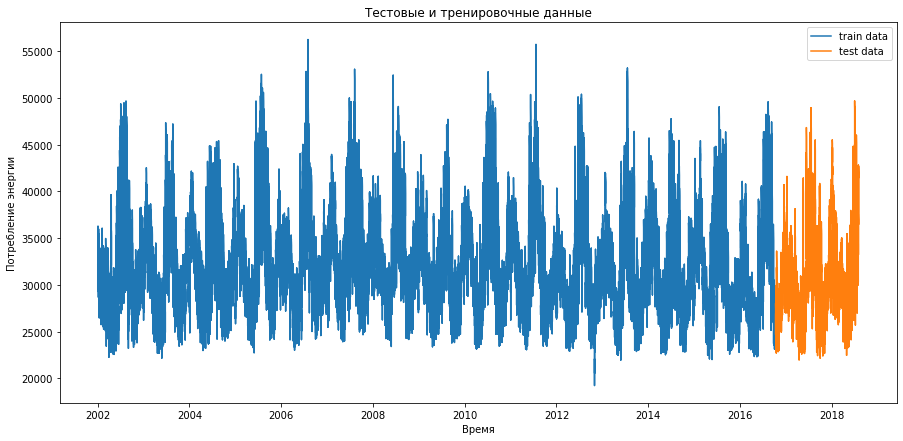

In [15]:
train, test = split_data(df_, '10-10-2016')

X_train = train.iloc[:-1,:]
y_train = train[df_.columns[0]].values[1:]
X_test = test.iloc[:-1,:]
y_test = test[df_.columns[0]].values[1:]


plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Потребление энергии')
plt.plot(train.index.get_level_values('Date'),train[df_.columns[0]], label='train data' )
plt.plot(test.index.get_level_values('Date'),test[df_.columns[0]], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

__Построим две модели, с глубиной прогноза h=1 и h =10__

In [16]:
# модель с глубиной прогноза h=1
model = CatBoostRegressor(max_depth=15, random_state=42, n_estimators=100, silent=True)
model.fit(X_train, y_train) 

X_test_pred = model.predict(X_test)

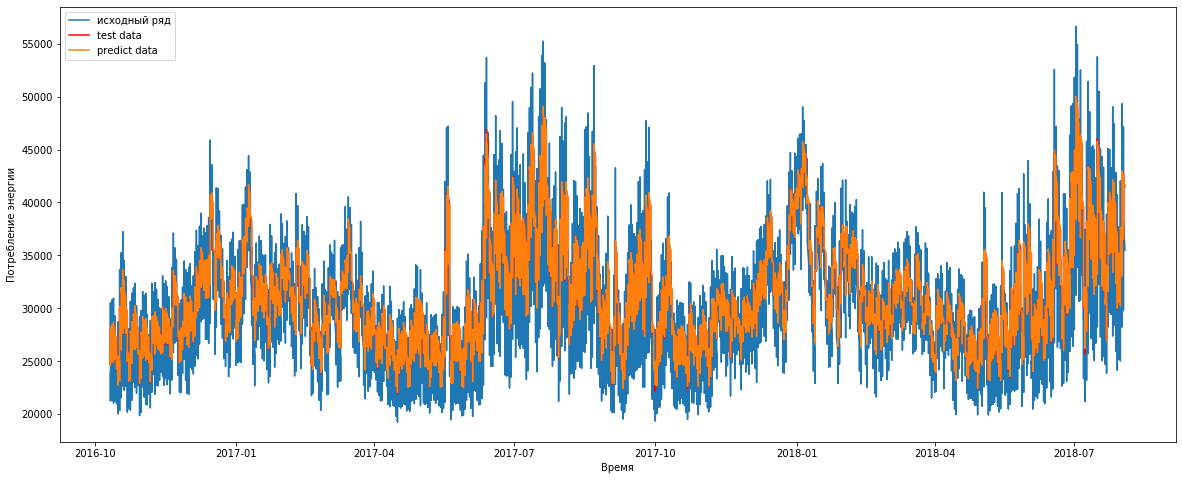

ошибка catb :   0.22963850582565357 %


In [17]:
plt.figure( figsize=(20, 8))
plt.xlabel('Время')
plt.ylabel('Потребление энергии')
plt.plot(df.loc['2016-10-11':].index, df.loc['2016-10-11':][PJME_MW], label='исходный ряд')
plt.plot(test.index[1:],y_test, label='test data', color='r')
plt.plot(test.index[1:],X_test_pred, label='predict data')
plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true=y_test, y_pred=X_test_pred)

print('ошибка catb :  ', er_g, '%')

Модель с h=1 работает отлично, ошибка _0.22%_ 

Теперь посмтроим такую же модель с h=10

In [18]:
h = 10
X_train = train.iloc[:-h,:]
y_train = train[df_.columns[0]].values[h:]
X_test = test.iloc[:-h,:]
y_test = test[df_.columns[0]].values[h:]

model.fit(X_train, y_train) 
X_test_pred = model.predict(X_test)

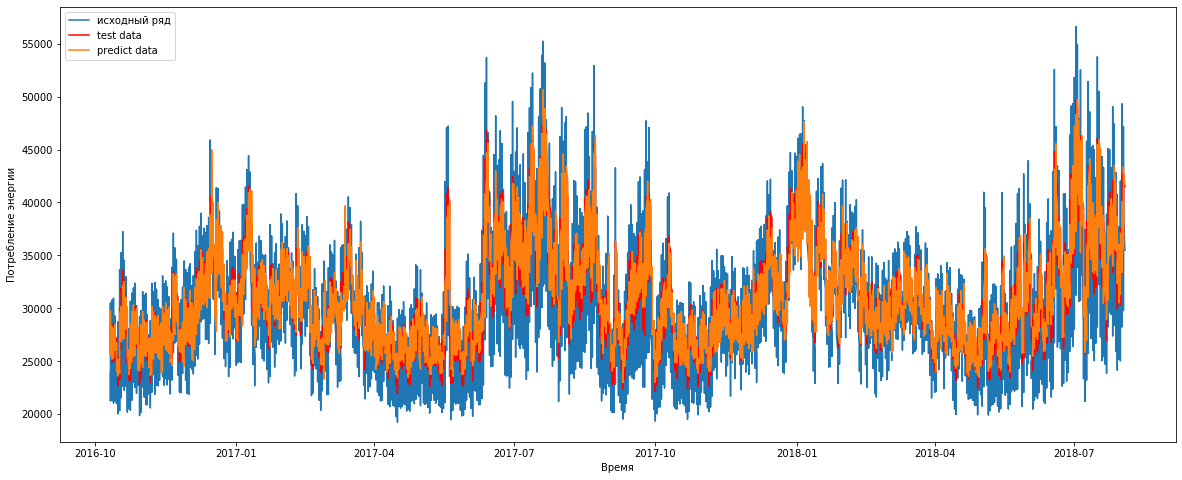

ошибка catb :   4.789804244381695 %


In [19]:
plt.figure( figsize=(20, 8))
plt.xlabel('Время')
plt.ylabel('Потребление энергии')
plt.plot(df.loc['2016-10-11':].index, df.loc['2016-10-11':][PJME_MW], label='исходный ряд')
plt.plot(test.index[h:],y_test, label='test data', color='r')
plt.plot(test.index[h:],X_test_pred, label='predict data')
plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true=y_test, y_pred=X_test_pred)

print('ошибка catb :  ', er_g, '%')

Как и ожидалось, с h=10 модель работает не так хорошо. Ошибка сильно выросла.

Очевидно, основная проблема состоит в формировании и подборе признаков.

### Задание 4
Попробуйте предположить характер ряда (стационарный или нет, с трендом, с сезоном, с циклом) для рядов из списка и аргументируйте свой ответ (одна строка):

    а) Изменение температуры за окном :).
        Циклический ряд с сезонами, станционарный если вычесть сезон
    
    б) Количество денег, которые тратят покупатели в интернет магазине.
        Скорее всегда также сезонный, например перед празниками покупок явно становится больше. 
        
    в) Вес растущего котенка.
        С трендом, станционарный если вычесть тренд
        
    г) Прирост объема деревьев в лесу от времени
        Не станционарный, в данный момент думаю с трендом(и думаю к сожалению это нисходящий тренд :( ). Возможно так же есть какие то циклы(летние пожары например)